In [1]:
%matplotlib inline
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy.ma as ma
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
import matplotlib

In [38]:
dateBegin = datetime(2020, 1, 2)
dateEnd = dateBegin + timedelta(days=1)
hours = np.arange(dateBegin, dateEnd, timedelta(hours=1)).astype(datetime)

In [39]:
day = hours[0]
radar = Dataset('/data/obs/site/jue/joyrad35/wind_ppi/data/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%Y%m%d")+'_joyrad35_wind_profile.nc', mode='r')
lidar = Dataset('/data/obs/site/jue/wind_lidar/l1/'+day.strftime("%Y")+'/'+day.strftime("%m")+'/'+day.strftime("%d")+'/wind_vad-36_'+day.strftime("%Y%m%d")+'.nc', mode='r')

In [40]:
# Radar
time_radar = radar.variables['time'][:]
time_var = radar.variables['time']
time_radar = (time_radar-2440587.5)*86400
#time = num2date(time, 'seconds since 1970-01-01T00:00:00', 'julian')
height_radar = radar.variables['height'][:]
speed_radar = radar.variables['speed'][:]
speed_radar_delta = radar.variables['delta_speed'][:]
#wind_vec = radar.variables['wind_vec'][:]
# Lidar
time_lidar = lidar.variables['time'][:]
time_var = lidar.variables['time']
time_lidar = (time_lidar-2440587.5)*86400
#time = num2date(time, 'seconds since 1970-01-01T00:00:00', 'julian')
height_lidar = lidar.variables['height'][:]
speed_lidar = lidar.variables['speed'][:]
speed_lidar_delta = lidar.variables['delta_speed'][:]
#wind_vec = lidar.variables['wind_vec'][:]

## map time

In [41]:
gridTimeSeries = []
for entry in hours:
    gridTimeSeries.append(datetime.timestamp(entry))
gridDf = pd.DataFrame({'time': gridTimeSeries})  
def timeknn(TimeSeries):

    
    
    
    #Target Grid
    #targetTimeList = []
    #for entry in TimeSeries:
    #    stamp = (entry-2440587.5)*86400
    #    targetTimeList.append(stamp)
    targetDf = pd.DataFrame({'time': TimeSeries})
    
    #KNN
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(targetDf)
    matchList = knn.kneighbors(gridDf, return_distance=True)
    

    #generate result
    resultList = []
    for i in range(len(gridTimeSeries)):
        iMatch = int(matchList[1][i])
        if matchList[0][i] <= 60*29: #14 Minuten
            resultList.append(iMatch)
        else:
        #    print("nan")
            resultList.append(np.nan)
        #resultList.append(iMatch)
    return resultList

radarTimeMatchIndex = timeknn(time_radar)
lidarTimeMatchIndex = timeknn(time_lidar)


## map heights

In [42]:
heightGrid = list(range(0,15000,50))
heightGridDf = pd.DataFrame({'height': heightGrid})
heightLidarDf = pd.DataFrame({'height': height_lidar})
heightRadarDf = pd.DataFrame({'height': height_radar})
knn = NearestNeighbors(n_neighbors=1)
#Radar
knn.fit(heightRadarDf)
radarMatchIndex = knn.kneighbors(heightGridDf, return_distance=False)
#Lidar
knn.fit(heightLidarDf)
lidarMatchIndex = knn.kneighbors(heightGridDf, return_distance=False)

## check availability

In [43]:
# create result array
availability = np.zeros((len(hours),300))
# no data = 0
# only radar = 1
# only lidar = 2
# both = 3
for n in range(len(hours)):
    nRadar = radarTimeMatchIndex[n]
    nLidar = lidarTimeMatchIndex[n]
    for i in range(0,300):
        iRadar = radarMatchIndex[i]
        iLidar = lidarMatchIndex[i]
        if not np.isnan(nRadar):
            if not ma.is_masked(speed_radar[nRadar,iRadar]):
                availability[n][i]=1
        if not np.isnan(nLidar):
            if not ma.is_masked(speed_lidar[iLidar,nLidar]):
                if availability[n,i] == 1:
                    availability[n,i]=3
                else:
                    availability[n,i]=2

## Difference

In [44]:
difference = np.zeros((len(hours),300))
speed_radar_fill = np.ma.filled(speed_radar, fill_value=0.)
speed_radar_delta_fill = np.ma.filled(speed_radar_delta, fill_value=0.)
speed_lidar_fill = np.ma.filled(speed_lidar, fill_value=0.)
speed_lidar_delta_fill = np.ma.filled(speed_lidar_delta, fill_value=0.)

for n in range(len(hours)):
    nRadar = radarTimeMatchIndex[n]
    nLidar = lidarTimeMatchIndex[n]
    for i in range(0,300):
        iRadar = radarMatchIndex[i]
        iLidar = lidarMatchIndex[i]
        if not np.isnan(nRadar) and not np.isnan(nLidar):
            if not ((speed_lidar_delta_fill[iLidar,nLidar]) == 0 or (speed_radar_delta_fill[nRadar,iRadar]) == 0):
                difference[n][i]= speed_radar_fill[nRadar,iRadar]-speed_lidar_fill[iLidar,nLidar]
            else:
                difference[n][i] =float("nan")
        else:
            difference[n][i] =float("nan")

## data fusion

In [45]:
#methode 2
speed_radar_fill = np.ma.filled(speed_radar, fill_value=0.)
speed_radar_delta_fill = np.ma.filled(speed_radar_delta, fill_value=0.)
speed_lidar_fill = np.ma.filled(speed_lidar, fill_value=0.)
speed_lidar_delta_fill = np.ma.filled(speed_lidar_delta, fill_value=0.)


result = np.zeros((24,300))







for n in range(0,24):
    nRadar = radarTimeMatchIndex[n]
    nLidar = lidarTimeMatchIndex[n]
    for i in range(0,300):
        iRadar = radarMatchIndex[i]
        iLidar = lidarMatchIndex[i]
        if not np.isnan(nRadar) and not np.isnan(nLidar):
            if not ((speed_lidar_delta_fill[iLidar,nLidar]+speed_radar_delta_fill[nRadar,iRadar]) == 0):
                result[n][i]=(speed_radar_fill[nRadar,iRadar]*speed_radar_delta_fill[nRadar,iRadar]+speed_lidar_fill[iLidar,nLidar]*speed_lidar_delta_fill[iLidar,nLidar])/(speed_lidar_delta_fill[iLidar,nLidar]+speed_radar_delta_fill[nRadar,iRadar]);
            else:
                result[n][i] =float("nan")
        else:
            result[n][i] =float("nan")

## Plot

In [46]:
# map lidar
speed_result = np.zeros((len(hours),300))
for n in range(len(hours)):
    nLidar = lidarTimeMatchIndex[n]
    for i in range(0,300):
        iLidar = lidarMatchIndex[i]
        if not np.isnan(nLidar):
            if np.isnan(speed_lidar[iLidar,nLidar]):
                speed_result[n][i] = np.nan
            else:
                speed_result[n][i] = speed_lidar[iLidar,nLidar]
        else:
            speed_result[n][i] = np.nan
speed_lidar = speed_result

In [47]:
#map radar
speed_result = np.zeros((len(hours),300))
for n in range(len(hours)):
    nRadar = radarTimeMatchIndex[n]
    for i in range(0,300):
        iRadar = radarMatchIndex[i]
        if not np.isnan(nRadar):
            if np.isnan(speed_radar.T[iRadar,nRadar]):
                speed_result[n][i] = np.nan
            else:
                speed_result[n][i] = speed_radar.T[iRadar,nRadar]
        else:
            speed_result[n][i] = np.nan
speed_radar = speed_result

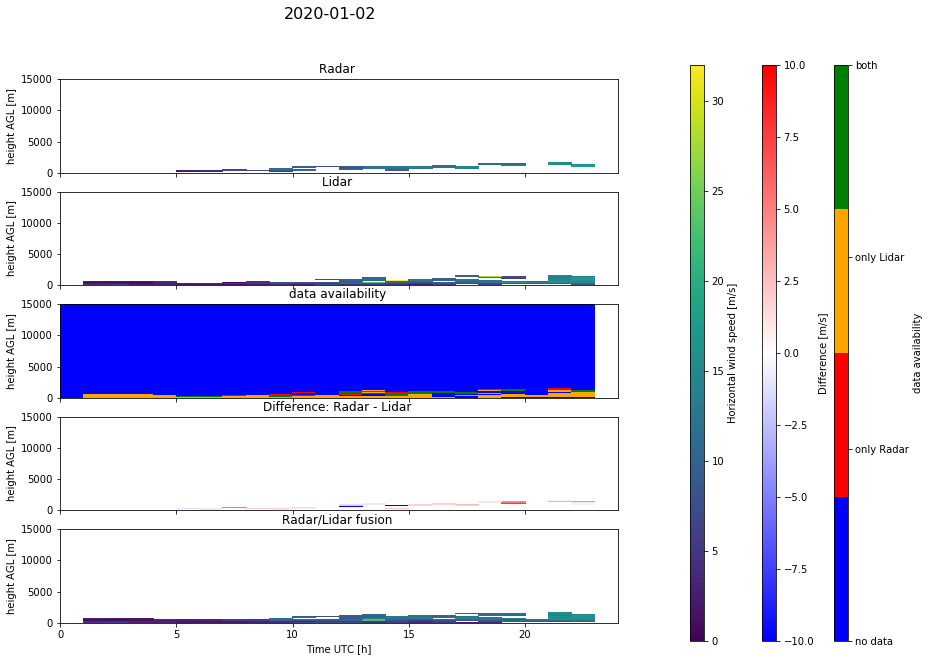

In [48]:
maxHeight = 15000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True, sharey=False)
fig.suptitle(day.strftime("%Y-%m-%d"), fontsize=16)


# Radar
axes[0].set_title("Radar ")
axes[0].axis([0, 24, 0, maxHeight])
X,Y = np.meshgrid(range(24), heightGrid)
im = axes[0].pcolor(X,Y,speed_radar.T,cmap='viridis', vmin=0, vmax=32)
axes[0].set_ylabel("height AGL [m]")

# Lidar
axes[1].set_title("Lidar ")
axes[1].axis([0, 24, 0, maxHeight])
X,Y = np.meshgrid(range(24), heightGrid)
im = axes[1].pcolor(X,Y,speed_lidar.T,cmap='viridis', vmin=0, vmax=32)
axes[1].set_ylabel("height AGL [m]")

# Availability
col_dict={1:"blue", 2:"red", 13:"orange", 7:"green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
X,Y = np.meshgrid(range(24), heightGrid)
im2 = axes[2].pcolor(X,Y,availability.T,cmap=cm, vmin=0, vmax=3)
axes[2].set_title("data availability ")
axes[2].axis([0, 24, 0, maxHeight])
axes[2].set_ylabel("height AGL [m]")

# Difference
X,Y = np.meshgrid(range(24), heightGrid)
im3 = axes[3].pcolor(X,Y,difference.T,cmap='bwr', vmin=-10, vmax=10)
axes[3].axis([0, 24, 0, maxHeight])
axes[3].set_title("Difference: Radar - Lidar ")
axes[3].set_ylabel("height AGL [m]")

# Fusion
X,Y = np.meshgrid(range(24), heightGrid)
im = axes[4].pcolor(X,Y,result.T,cmap='viridis', vmin=0, vmax=32)
axes[4].axis([0, 24, 0, maxHeight])
axes[4].set_title("Radar/Lidar fusion ")
axes[4].set_xlabel("Time UTC [h]")
axes[4].set_ylabel("height AGL [m]")

# cbar speed
cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Horizontal wind speed [m/s]')

# cbar availability
cb_ax2 = fig.add_axes([1.2, 0.1, 0.02, 0.8])
cbar2 = fig.colorbar(im2, cax=cb_ax2, ticks=[0,1,2,3])
cbar2.set_ticks([0,1,2,3])
cbar2.set_ticklabels(["no data", "only Radar", "only Lidar","both"])
cbar2.set_label('data availability')

# cbar difference
cb_ax3 = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar3 = fig.colorbar(im3, cax=cb_ax3)
cbar3.set_label('Difference [m/s]')

plt.show()